In [1]:
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import itertools
from glob import glob

In [2]:
def get_stats(df, y_col, method_list):
    r2_list = []
    rmse_list = []
    for k,v in test_df.groupby("fold"):
        r2_list.append([r2_score(v[y_col],v[x]) for x in method_list])
        rmse_list.append([root_mean_squared_error(v[y_col],v[x]) for x in method_list])
    r2_df = pd.DataFrame(r2_list,columns=method_list)
    rmse_df = pd.DataFrame(rmse_list,columns=method_list)
    r2_melt_df = r2_df.melt()
    r2_melt_df.columns = ["method","r2"]
    rmse_melt_df = rmse_df.melt()
    rmse_melt_df.columns = ["method","rmse"]
    return r2_melt_df, rmse_melt_df

def make_boxplots(r2_melt_df, rmse_melt_df):
    figure, axes = plt.subplots(1,2,figsize=(10,5))
    ax0 = sns.boxplot(x="method",y="r2",data=r2_melt_df,ax=axes[0])
    ax0.set_xlabel("Method")
    ax0.set_ylabel("$R^2$")
    ax1 = sns.boxplot(x="method",y="rmse",data=rmse_melt_df,ax=axes[1])
    ax1.set_xlabel("Method")
    ax1.set_ylabel("RMSE")

def evaluate_hsd(df_in,stat_col,method_col):
    hsd_res = pairwise_tukeyhsd(df_in[stat_col],r2_melt_df[method_col])
    print(hsd_res)
    _ = hsd_res.plot_simultaneous(figsize=(5,3))

def tukey_boxplot(df_in, x_col, y_col, x_label, y_label, ax, title=""):
    tukey = pairwise_tukeyhsd(endog=df_in[y_col], groups=df_in[x_col], alpha=0.05)
    ax = sns.boxplot(x=x_col,y=y_col,data=df_in,ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    pairs = list(itertools.combinations(df_in[x_col].unique(),2))
    annotator = Annotator(ax, pairs, data=df_in, x=x_col, y=y_col, verbose=False)
    annotator.configure(text_format='star', loc='inside')
    _ = annotator.set_pvalues_and_annotate(tukey.pvalues)

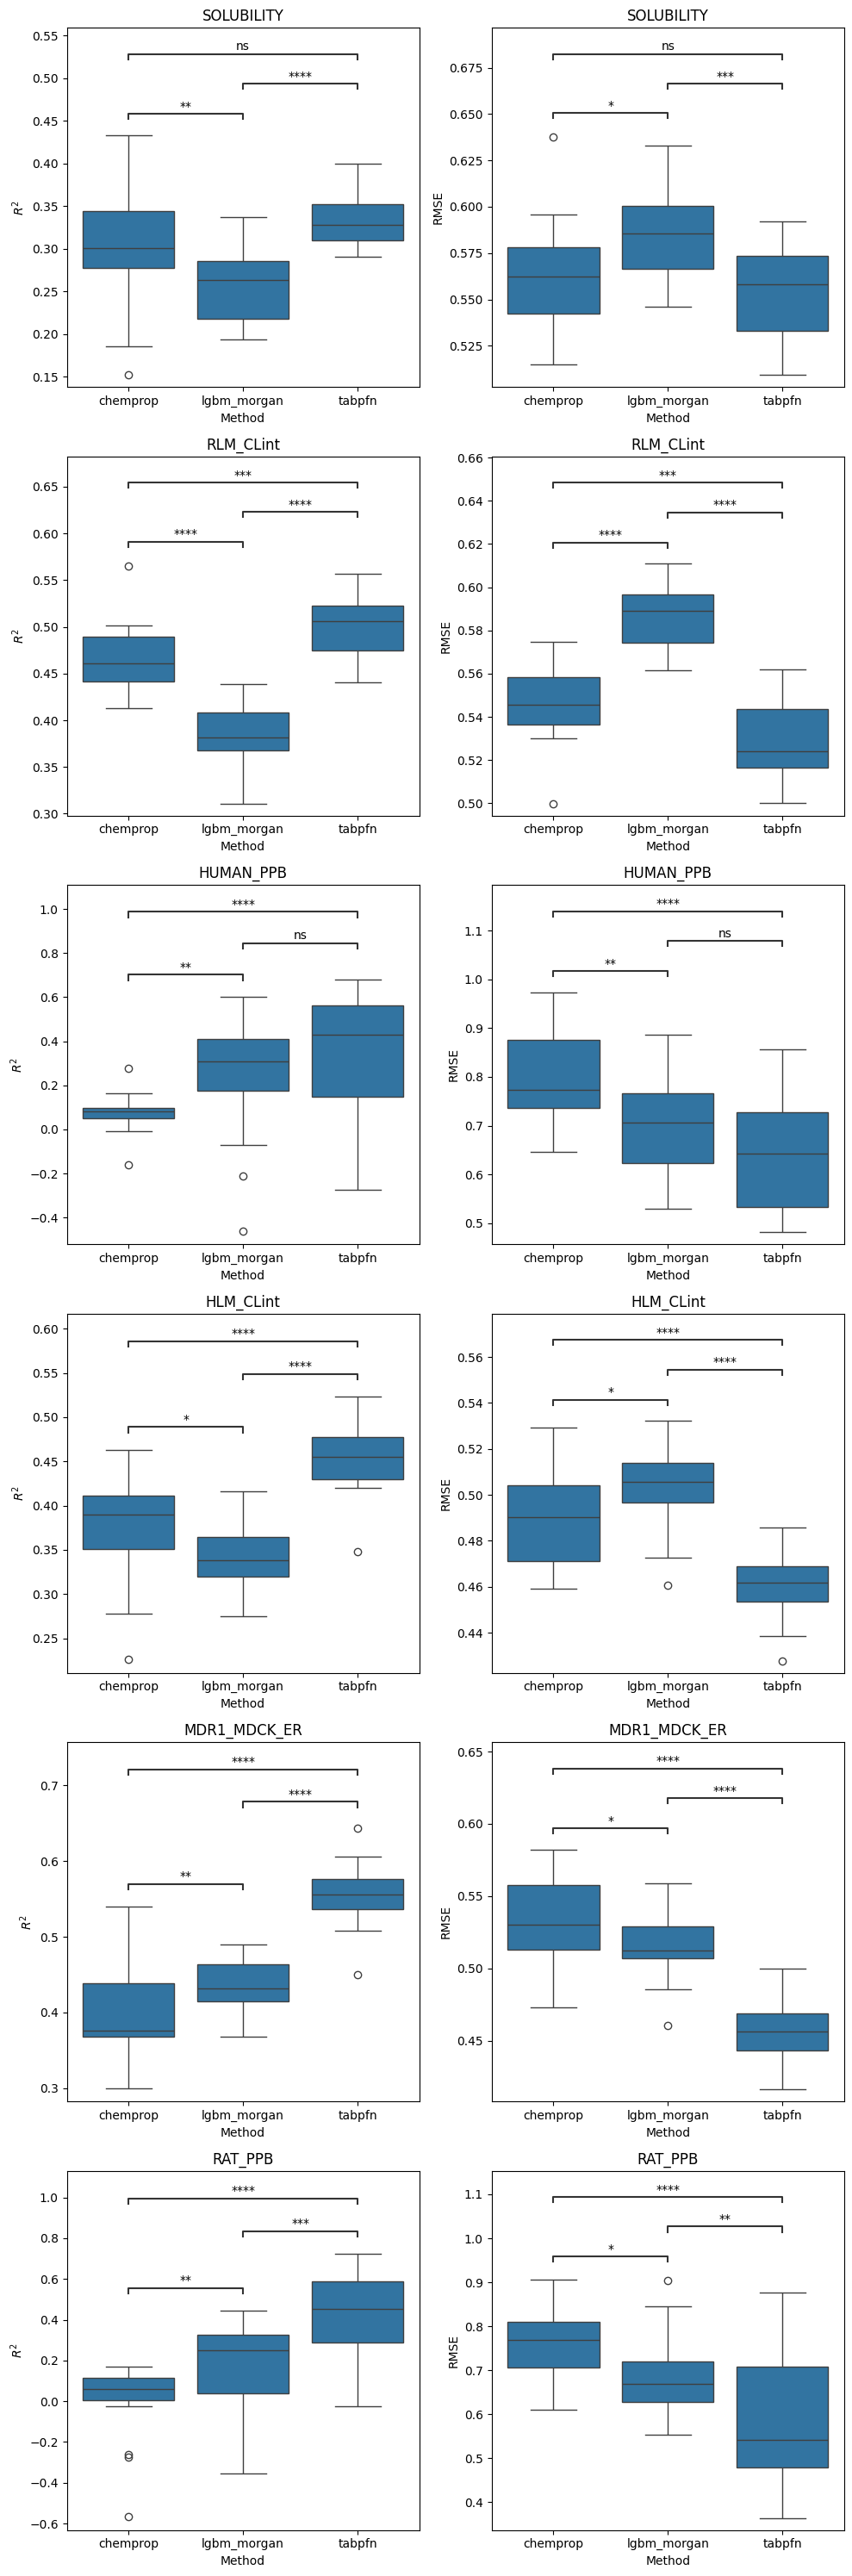

In [3]:
method_list = ["chemprop", "lgbm_morgan", "tabpfn"]
assay_list = [x.replace("_results.csv","") for x in glob("*results.csv")]
figure, axes = plt.subplots(len(assay_list),2,figsize=(10,5*len(assay_list)))
axes = axes.flatten()
assay_list = [x.replace("_results.csv","") for x in glob("*results.csv")]
for idx,assay_name in enumerate(assay_list):
    input_df = pd.read_csv(f"{assay_name}_results.csv")
    test_df = input_df.query("dset == 'test' and group == 'butina'")    
    r2_melt_df, rmse_melt_df = get_stats(test_df,assay_name, method_list)
    tukey_boxplot(r2_melt_df,"method", "r2", "Method", "$R^2$",axes[idx*2],assay_name)
    tukey_boxplot(rmse_melt_df,"method", "rmse", "Method", "RMSE",axes[idx*2+1],assay_name)
plt.tight_layout()